In [2]:
#Importing the libaries

In [3]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
# Setup paths

In [5]:
app_path = os.path.abspath(os.path.join(os.getcwd(), "..", "backend", "app"))
if app_path not in sys.path:
    sys.path.insert(0, app_path)

In [6]:
# Import our modules

In [7]:
from services.mde_calculator import MDECalculator, quick_sample_size, quick_mde
from services.experimentation import calculate_cuped_adjusted_metric
from utils.experiment_data import fetch_experiment_data

# Initialize calculator
calc = MDECalculator()

In [8]:
#E-commerce Conversion Rate Experiment

In [9]:
baseline_cvr = 0.08  # 8% baseline conversion
target_uplift = 0.15  # 15% relative increase (to 9.2%)

sample_result = calc.calculate_sample_size_binary(
    mde_relative=target_uplift,
    baseline_rate=baseline_cvr,
    power=0.8,
    alpha=0.05,
    variance_reduction=0.0  # No CUPED yet
)

print(f"Baseline conversion rate: {baseline_cvr:.1%}")
print(f"Target uplift: {target_uplift:.1%}")
print(f"Target conversion rate: {sample_result['treatment_rate_target']:.2%}")
print(f"Required sample size per group: {sample_result['sample_size_control']:,}")
print(f"Total sample size needed: {sample_result['total_sample_size']:,}")
print(f"Experiment duration (1000 visitors/day): {sample_result['total_sample_size']/1000:.0f} days")

Baseline conversion rate: 8.0%
Target uplift: 15.0%
Target conversion rate: 9.20%
Required sample size per group: 8,024
Total sample size needed: 16,048
Experiment duration (1000 visitors/day): 16 days


In [10]:
# With CUPED improvement

In [11]:
print(f"With CUPED (assuming 30% covariate correlation):")
sample_cuped = calc.calculate_sample_size_binary(
    mde_relative=target_uplift,
    baseline_rate=baseline_cvr,
    power=0.8,
    alpha=0.05,
    variance_reduction=0.3**2  # 30% correlation = 9% variance reduction
)

reduction = (sample_result['sample_size_control'] - sample_cuped['sample_size_control']) / sample_result['sample_size_control']
print(f"Required sample size with CUPED: {sample_cuped['sample_size_control']:,}")
print(f"Sample size reduction: {reduction:.1%}")
print(f"Time saved: {(sample_result['total_sample_size'] - sample_cuped['total_sample_size'])/1000:.0f} days")

With CUPED (assuming 30% covariate correlation):
Required sample size with CUPED: 7,302
Sample size reduction: 9.0%
Time saved: 1 days


In [12]:
#Revenue Per User (Continuous Metric)

In [13]:
baseline_rpu = 25.0  # $25 average revenue per user
target_increase = 2.0  # $2 absolute increase (8% relative)
rpu_std = 15.0  # $15 standard deviation

sample_continuous = calc.calculate_sample_size_continuous(
    mde=target_increase,
    pooled_std=rpu_std,
    power=0.8,
    alpha=0.05,
    variance_reduction=0.0
)

print(f"Baseline RPU: ${baseline_rpu:.2f}")
print(f"Target increase: ${target_increase:.2f} ({target_increase/baseline_rpu:.1%})")
print(f"Standard deviation: ${rpu_std:.2f}")
print(f"Required sample size per group: {sample_continuous['sample_size_control']:,}")

Baseline RPU: $25.00
Target increase: $2.00 (8.0%)
Standard deviation: $15.00
Required sample size per group: 883


In [14]:
#Power Analysis Visualization

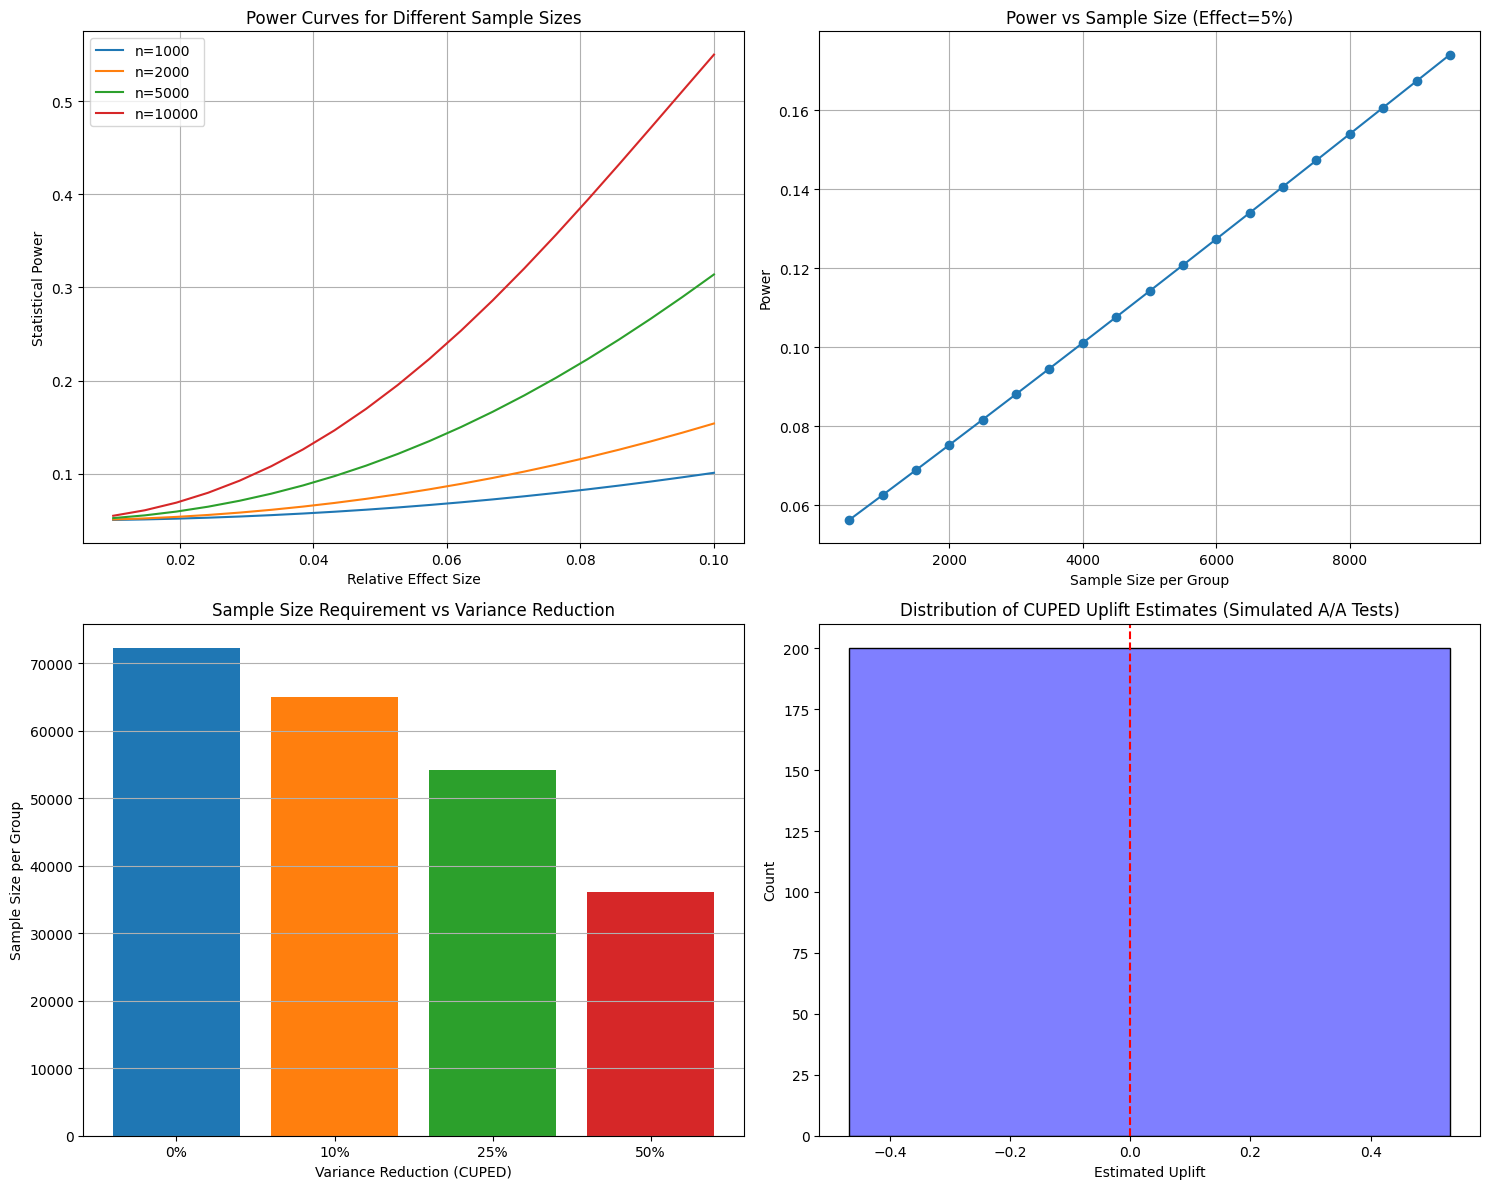

In [21]:
# Create power curves for different sample sizes
effect_sizes = np.linspace(0.01, 0.10, 20)  # 1% to 10% relative effects
sample_sizes = [1000, 2000, 5000, 10000]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Power curves
ax = axes[0, 0]
for n in sample_sizes:
    powers = []
    for effect in effect_sizes:
        mde_result = calc.calculate_mde_binary(
            sample_size_per_group=n,
            baseline_rate=baseline_cvr,
            variance_reduction=0.0
        )
        
        # Calculate power for this effect size
        se = mde_result['se_difference']
        z_alpha = stats.norm.ppf(1 - 0.05/2)
        z_score = (baseline_cvr * effect) / se
        power = stats.norm.cdf(z_score - z_alpha) + (1 - stats.norm.cdf(z_score + z_alpha))
        powers.append(power)
    
    ax.plot(effect_sizes, powers, label=f'n={n}')

ax.set_title("Power Curves for Different Sample Sizes")
ax.set_xlabel("Relative Effect Size")
ax.set_ylabel("Statistical Power")
ax.legend()
ax.grid(True)

# Power vs Sample Size (fixed effect size)
ax = axes[0, 1]
fixed_effect = 0.05  # 5% relative increase
sample_sizes_range = np.arange(500, 10000, 500)
powers = []
for n in sample_sizes_range:
    mde_result = calc.calculate_mde_binary(
        sample_size_per_group=n,
        baseline_rate=baseline_cvr,
        variance_reduction=0.0
    )
    se = mde_result['se_difference']
    z_alpha = stats.norm.ppf(1 - 0.05/2)
    z_score = (baseline_cvr * fixed_effect) / se
    power = stats.norm.cdf(z_score - z_alpha) + (1 - stats.norm.cdf(z_score + z_alpha))
    powers.append(power)

ax.plot(sample_sizes_range, powers, marker="o")
ax.set_title(f"Power vs Sample Size (Effect={fixed_effect:.0%})")
ax.set_xlabel("Sample Size per Group")
ax.set_ylabel("Power")
ax.grid(True)

# CUPED Effect (Variance Reduction) Comparison
ax = axes[1, 0]
variance_reductions = [0.0, 0.1, 0.25, 0.5]
for vr in variance_reductions:
    mde_result = calc.calculate_sample_size_binary(
        mde_relative=fixed_effect,
        baseline_rate=baseline_cvr,
        power=0.8,
        alpha=0.05,
        variance_reduction=vr
    )
    ax.bar(f"{int(vr*100)}%", mde_result['sample_size_control'])

ax.set_title("Sample Size Requirement vs Variance Reduction")
ax.set_ylabel("Sample Size per Group")
ax.set_xlabel("Variance Reduction (CUPED)")
ax.grid(True, axis="y")

# Distribution of estimated MDEs (simulated)
ax = axes[1, 1]
simulated_mdes = []
for i in range(200):
    data = fetch_experiment_data("exp_demo", num_samples=2000)
    control = data[data["treatment"] == 0]
    treatment = data[data["treatment"] == 1]
    results = calculate_cuped_adjusted_metric(
        control["outcome"].values,
        control["pre_metric"].values,
        treatment["outcome"].values,
        treatment["pre_metric"].values
    )
    simulated_mdes.append(results["uplift_cuped"])

sns.histplot(simulated_mdes, kde=True, ax=ax, color="blue")
ax.set_title("Distribution of CUPED Uplift Estimates (Simulated A/A Tests)")
ax.set_xlabel("Estimated Uplift")
ax.axvline(0, color="red", linestyle="--")

plt.tight_layout()
plt.show()